# Hard spheres model development


First stage: Develop a CNN - based GAN to work with ordered point clouds.

## Imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# Basic
from IPython.display import display

# For OS-agnostic paths
from pathlib import Path

# Plotting
from matplotlib import pyplot as plt
import seaborn as sns
import torch
from torch import nn
import pandas as pd
import numpy as np
sns.set_style("whitegrid")
from copy import deepcopy
import glob, json
from datetime import datetime
import torch
from torch import nn

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import DataLoader, Dataset, TensorDataset


from torchinfo import summary

import mlflow

%cd ..

from src.utils import load_raw_data
from src.plotting import plot_pointcloud, plot_sample_figures
from src.models.HardSphereGAN import GAN, HSGenerator, HSDiscriminator

%cd -

/Users/veikko/Documents/GitHub/hard-spheres
/Users/veikko/Documents/GitHub/hard-spheres/Notebooks


## Load data

In [3]:

phis = [0.84] # Add more phis here

path = Path("../data/raw/samples")

files, dataframe, metadata = load_raw_data(path, phi=phis)

dataframe

Number of Files found :  500


class          x          y         r
experiment sample                                           
phi-0.84   sample-245     12  17.442748 -17.081946  1.245263
           sample-245      1  14.625251  14.245529  0.730000
           sample-245      3 -19.113390  20.579243  0.823684
           sample-245      3 -17.980250 -10.332299  0.823684
           sample-245     11 -12.854737 -11.140054  1.198421
...                      ...        ...        ...       ...
           sample-468      4  -2.095901 -10.645402  0.870526
           sample-468      1  -9.926513 -21.086970  0.730000
           sample-468      5  12.349411  21.396939  0.917368
           sample-468      2  -7.728623 -19.221233  0.776842
           sample-468     17  18.675725  -5.638693  1.479474

[1000000 rows x 4 columns]

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

dataframe_scaled = pd.DataFrame(scaler.fit_transform(dataframe), columns=dataframe.columns)

dataframe_scaled.set_index(dataframe.index, inplace=True)

dataframe_scaled = dataframe_scaled.drop(columns=["class"]) # Redundant with r

### IMPORTANT: Order dataframe based on Xy coordinates

This is done to introduce the spatial relationship that a CNN can utilize.


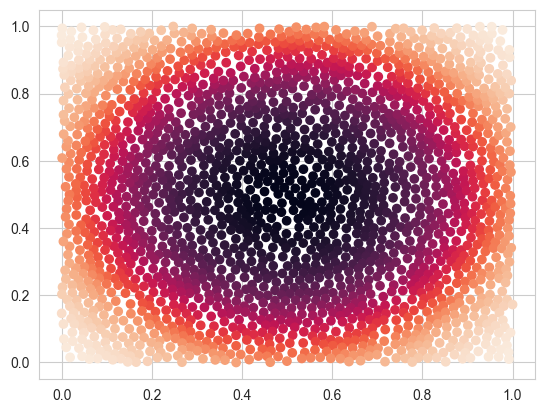

In [5]:
_X = dataframe_scaled.copy()
_X["Xy"] = _X["x"] + _X["y"] # Think about starting from center and going radially outwards


_X["Xy"] = np.sqrt(((_X["x"]-0.5)**2) + ((_X["y"]-0.5)**2))

_X = _X.query("experiment=='phi-0.84'&sample=='sample-1'")

_X = _X.sort_values(by=["Xy", "x", "y"])

_X = _X.reset_index(drop=True)

_X

plt.scatter(x=_X.values[:,0], y=_X.values[:,1], c=_X.index)


This is better than not ordered, but can be problematic as values in the middle have a high probability of ending up with non-neighbouring samples.

However it is also a good experiment as if we observe that the corners behave better than the middle, we know we are on to something.

In [6]:
dataframe_scaled_ordered = dataframe_scaled.copy()
dataframe_scaled_ordered["Xy"] = np.sqrt(((dataframe_scaled_ordered["x"]-0.5)**2) + ((dataframe_scaled_ordered["y"]-0.5)**2))
dataframe_scaled_ordered = dataframe_scaled_ordered.sort_values(by=["experiment", "sample", "Xy"])
dataframe_scaled_ordered = dataframe_scaled_ordered.drop(columns=["Xy"])

## Build dataset

In [7]:
from src.HSDataset import HSDataset

dataset = HSDataset(dataframe_scaled_ordered, descriptor_list=["phi"])

Creating Dataset
Descriptor List:  ['phi']


In [8]:
print(dataset[:][0].shape)
print(dataset[:][1].shape)

torch.Size([500, 1, 3])
torch.Size([500, 2000, 3])


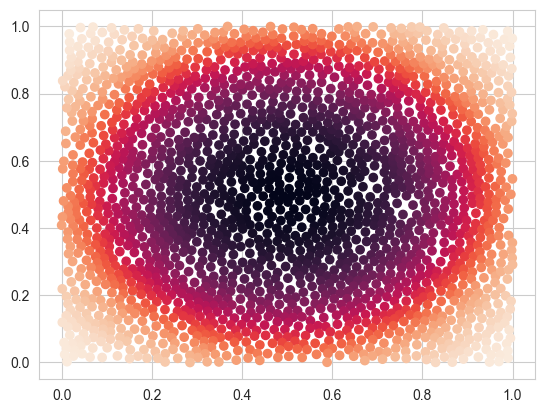

In [9]:
plt.scatter(x=dataset[2][1][:,0], y=dataset[2][1][:,1], c=list(range(len(dataset[2][1]))))


<Axes: >

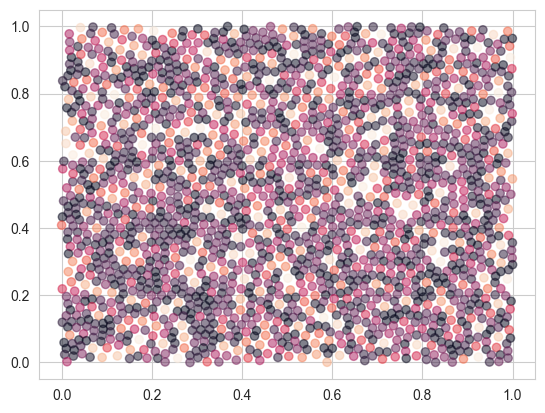

In [10]:
# Create a function that visualizes the point cloud

plot_pointcloud(dataset[2][1], plot_radius=False)

## Note: Samples are order invariant in the sample size dimension

<Axes: >

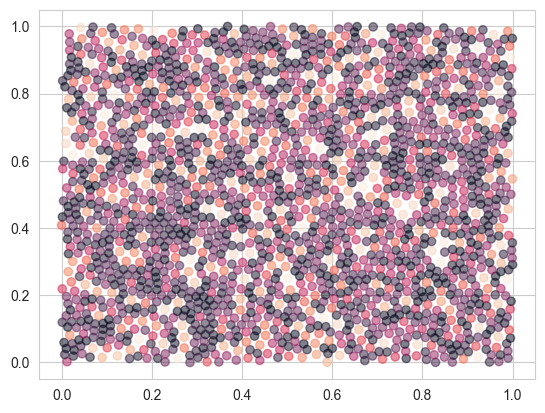

In [11]:
plot_pointcloud(reversed(dataset[2][1]), plot_radius=False)


## Check on x, y, r distributions

<Axes: xlabel='r', ylabel='Count'>

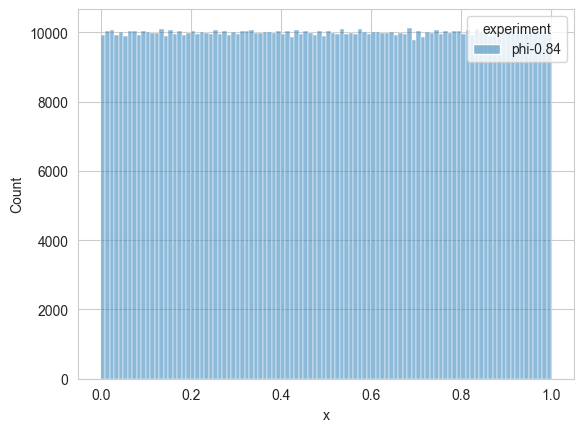

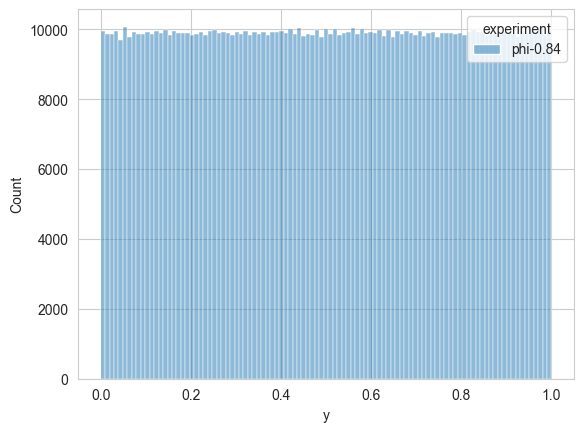

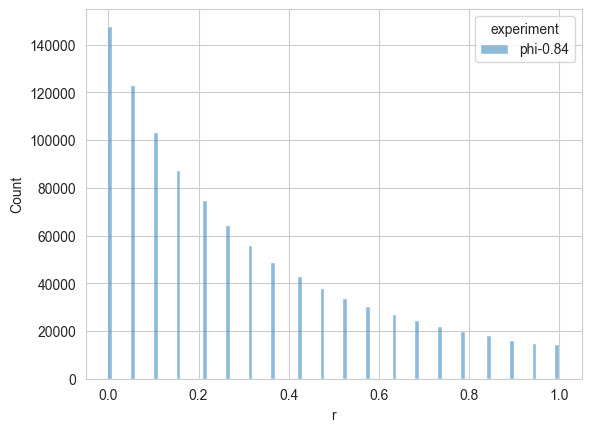

In [12]:
plt.figure()
sns.histplot(dataframe_scaled, x="x", hue="experiment", bins="auto")
plt.figure()
sns.histplot(dataframe_scaled, x="y", hue="experiment", bins="auto")
plt.figure()
sns.histplot(dataframe_scaled, x="r", hue="experiment", bins="auto")

x, y are uniform distributions

r seems to be an 1/x

# Create model

Create a GAN architecture, which creates point clouds $\hat{y}$ based on the descriptor(s) $\hat{X}$ and a random noise vector $\hat{z}$.

In [13]:
sample_x = dataset[0:32][0]#.transpose(-1,-2)
sample_y = dataset[0:32][1]

print(sample_x.shape, sample_y.shape)

torch.Size([32, 1, 3]) torch.Size([32, 2000, 3])


## Play around with models

(array([39., 27., 20.,  8.,  2.,  2.,  1.,  0.,  0.,  1.]),
 array([0.00611534, 0.20649334, 0.40687133, 0.60724933, 0.80762733,
        1.00800533, 1.20838333, 1.40876133, 1.60913933, 1.80951733,
        2.00989533]),
 <BarContainer object of 10 artists>)

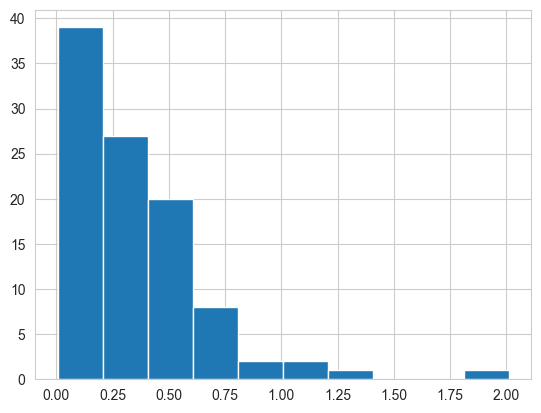

In [14]:
plt.hist(np.random.exponential(0.3, (100,1)))

In [15]:
output_max_samples = 2000
in_dim = 1 # We have a single descriptor

kernel_y = 64
cnn_layers = 3
latent_max_samples = output_max_samples + cnn_layers*kernel_y # We will add some padding to the latent space

latent_dim = 27 # This you can change
batch_size = sample_x.shape[0]
cnn_channels = 16

# Takes in the input descriptors and returns the output point cloud

desc2latent = nn.Sequential(
            # Input to latent space
            nn.ConvTranspose1d(in_dim, latent_dim//4, kernel_size=latent_max_samples//2, stride=1, padding=0, bias=True),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose1d(latent_dim//4, latent_dim, kernel_size=latent_max_samples//2-1, stride=1, padding=0, bias=True),
            nn.LeakyReLU(0.2),
        )

desc2latent_alt = nn.Sequential( # Do a version without the 1d transpose convolution
            nn.Linear(in_dim, latent_dim//4),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim//4, latent_dim),
            nn.LeakyReLU(0.2),
        )

# This is a good idea but difficult to implement with padding
# zx = torch.rand(batch_size, latent_max_samples, 1) # X is uniform
# zy = torch.rand(batch_size, latent_max_samples, 1) # Y is uniform
# # R is inverse exponential
# zr = torch.tensor(np.random.exponential(0.3, (batch_size, latent_max_samples, 1)), dtype=torch.float32)
# z = torch.cat([zx, zy, zr], dim=-1)

# Simple way
z = torch.rand(batch_size, latent_max_samples, latent_dim)

kernel_x = latent_dim // cnn_layers 

latent2pointcloud = nn.Sequential(
            nn.Conv2d(1, cnn_channels, kernel_size=(kernel_y+1, kernel_x), stride=1, padding=0, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(cnn_channels, cnn_channels, kernel_size=(kernel_y+1, kernel_x), stride=1, padding=0, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(cnn_channels, 1, kernel_size=(kernel_y+1, kernel_x), stride=1, padding=0, bias=False),
        )

print(r"X:", sample_x.shape)
print("Z:", z.shape)

x = sample_x
x = desc2latent(x)
print("mean:", x.mean(), x.min(), x.max())
x = x.transpose(-1,-2)

print("Latent:", x.shape)
x = x + z
x = z
x = x.unsqueeze(1)

print("Latent random: ", x.shape)

x = latent2pointcloud(x)
x = x.squeeze(1)
print("Point cloud: ", x.shape)

# print("Latent reshaped:", desc2latent(sample_x_2d).reshape(batch_size, 1, -1, latent_dim).shape)
# print("Latent reshaped:", desc2latent(sample_x_2d).transpose(-1,-2).reshape(batch_size, 1, -1, latent_dim).shape)
# print("Output:", latent2pointcloud((desc2latent(sample_x_2d).reshape(batch_size, 1, -1, latent_dim))).shape)
# print(latent2pointcloud((desc2latent(sample_x_2d).transpose(-1,-2)*z)).shape)

# print(summary(latent2pointcloud,depth=1))
print(summary(desc2latent,depth=0))
print(summary(latent2pointcloud,depth=0))
# latent2pointcloud(desc2latent(sample_x)*z).transpose(-1,-2).shape


X: torch.Size([32, 1, 3])
Z: torch.Size([32, 2192, 27])
mean: tensor(0.0016, grad_fn=<MeanBackward0>) tensor(-0.0023, grad_fn=<MinBackward1>) tensor(0.0124, grad_fn=<MaxBackward1>)
Latent: torch.Size([32, 2192, 27])
Latent random:  torch.Size([32, 1, 2192, 27])
Point cloud:  torch.Size([32, 2000, 3])
Layer (type:depth-idx)                   Param #
Sequential                               183,999
Total params: 183,999
Trainable params: 183,999
Non-trainable params: 0
Layer (type:depth-idx)                   Param #
Sequential                               168,480
Total params: 168,480
Trainable params: 168,480
Non-trainable params: 0


In [16]:
# print(HSGenerator(output_max_samples=dataset.y.shape[1], latent_dim=27, in_dim=3)(sample_x).shape)

summary(
    HSGenerator(output_max_samples=dataset.y.shape[1], latent_dim=9, in_dim=3, cnn_channels=4), input_data=sample_x
    )


Layer (type:depth-idx)                   Output Shape              Param #
HSGenerator                              [32, 2128, 9]             46,377
├─Sequential: 1-1                        [32, 1, 2128, 9]          --
│    └─Conv2d: 2-1                       [32, 4, 2256, 9]          264
│    └─BatchNorm2d: 2-2                  [32, 4, 2256, 9]          8
│    └─LeakyReLU: 2-3                    [32, 4, 2256, 9]          --
│    └─Conv2d: 2-4                       [32, 4, 2192, 9]          1,044
│    └─BatchNorm2d: 2-5                  [32, 4, 2192, 9]          8
│    └─LeakyReLU: 2-6                    [32, 4, 2192, 9]          --
│    └─Conv2d: 2-7                       [32, 4, 2192, 9]          1,044
│    └─BatchNorm2d: 2-8                  [32, 4, 2192, 9]          8
│    └─LeakyReLU: 2-9                    [32, 4, 2192, 9]          --
│    └─Conv2d: 2-10                      [32, 4, 2192, 9]          1,044
│    └─BatchNorm2d: 2-11                 [32, 4, 2192, 9]          8
│    

In [17]:
print(sample_x.shape)
print(sample_y.shape)
HSDiscriminator(channels_img=1, features_d=4)(sample_y).shape

summary(HSDiscriminator(channels_img=1, features_d=32), input_data=sample_y, depth=2)

torch.Size([32, 1, 3])
torch.Size([32, 2000, 3])


Layer (type:depth-idx)                   Output Shape              Param #
HSDiscriminator                          [32, 1]                   --
├─Sequential: 1-1                        [32, 1]                   --
│    └─Conv2d: 2-1                       [32, 16, 969, 2]          2,064
│    └─LeakyReLU: 2-2                    [32, 16, 969, 2]          --
│    └─Sequential: 2-3                   [32, 32, 314, 3]          32,832
│    └─Sequential: 2-4                   [32, 32, 301, 4]          32,832
│    └─Conv2d: 2-5                       [32, 1, 298, 3]           257
│    └─Flatten: 2-6                      [32, 894]                 --
│    └─MaxPool1d: 2-7                    [32, 178]                 --
│    └─Linear: 2-8                       [32, 32]                  5,728
│    └─LeakyReLU: 2-9                    [32, 32]                  --
│    └─Linear: 2-10                      [32, 1]                   33
│    └─Sigmoid: 2-11                     [32, 1]                   --


In [18]:
# if detect_bad_gradients:
#             with autograd.detect_anomaly():
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels, weights)  # Compute RMSE from MSE
#                 loss.backward()
#         else:
#             outputs = model(inputs)
#             loss = criterion(outputs, labels, weights)  # Compute RMSE from MSE
#             loss.backward()
#         grad_norm = torch.nn.utils.clip_grad_norm_(
#             model.parameters(), 50
#         )  # Clip gradients

## Train the model

In [19]:
run_params = {
    "training":{
        "device": "mps" if torch.backends.mps.is_available() else "cpu", # MPS is not supported by PyTorch 2D TransposeConv
        "batch_size": 32,
        "epochs": 300,
        "early_stopping_patience": 10,
        "early_stopping_headstart": 20,
        "log_image_frequency": 1,
        "optimizer_g": {
            "name": "AdamHD",
            "lr": 0.0001,
            "weight_decay": 1e-7,
            "hypergrad_lr": 1e-7
        },
        "optimizer_d": {
            "name": "AdamHD",
            "lr": 0.0001,
            "weight_decay": 1e-5,
            "hypergrad_lr": 1e-7
        },
    },
    "generator": {
        "output_max_samples": dataset.y.shape[1],
        "in_dim": 3,
        "latent_dim": 12,
        "cnn_channels": 16,
    },
    "discriminator": {
        "channels_img":1,
        "features_d": 12
    }
}
run_params

{'training': {'device': 'mps',
  'batch_size': 32,
  'epochs': 300,
  'early_stopping_patience': 10,
  'early_stopping_headstart': 20,
  'log_image_frequency': 1,
  'optimizer_g': {'name': 'AdamHD',
   'lr': 0.0001,
   'weight_decay': 1e-07,
   'hypergrad_lr': 1e-07},
  'optimizer_d': {'name': 'AdamHD',
   'lr': 0.0001,
   'weight_decay': 1e-05,
   'hypergrad_lr': 1e-07}},
 'generator': {'output_max_samples': 2000,
  'in_dim': 3,
  'latent_dim': 12,
  'cnn_channels': 16},
 'discriminator': {'channels_img': 1, 'features_d': 12}}

In [20]:
test_frac = 0.2

dataset = dataset.to(run_params["training"]["device"])

trainset, testset = torch.utils.data.random_split(dataset, [1-test_frac, test_frac])

sample_x = dataset[0:32][0]#.transpose(-1,-2)
sample_y = dataset[0:32][1]

len(trainset), len(testset)

(400, 100)

In [33]:
gan = GAN(trainset, testset, **run_params)

print(summary(gan.generator, input_data=sample_x, depth=2))
print(summary(gan.discriminator, input_data=sample_y, depth=2))


TypeError: super(type, obj): obj must be an instance or subtype of type

In [32]:
gan.train_n_epochs(
    epochs=run_params["training"]["epochs"],
    batch_size=run_params["training"]["batch_size"],
    experiment_name="MLFlow test",
    comment="",
)

Starting run star-tree-3ffdb25a-2231-4560-8cf7-817f7802279c...
Time: 2024-06-23 23:41:29


  0%|          | 0/300 [00:00<?, ?it/s]


RuntimeError: linear(): input and weight.T shapes cannot be multiplied (32x574 and 178x32)

In [24]:
# Run hyper parameter optimization
 
# Define the hyperparameter search space

batch_sizes = [16, 32, 64]
lrs_d = [0.001, 0.0001, 0.00001]
lrs_g = [0.001, 0.0001, 0.00001]

# Run experiments

this_run_params = deepcopy(run_params)

try:
    for batch_size in batch_sizes:
        for lr_d in lrs_d:
            for lr_g in lrs_g:
                this_run_params["training"]["batch_size"] = batch_size
                this_run_params["training"]["optimizer_g"]["lr"] = lr_g
                this_run_params["training"]["optimizer_d"]["lr"] = lr_d
                gan = GAN(trainset, testset, **this_run_params)
                gan.train_n_epochs(
                    epochs=this_run_params["training"]["epochs"],
                    batch_size=this_run_params["training"]["batch_size"],
                    experiment_name="Hparam search",
                    comment="",
                )
except KeyboardInterrupt:
    print("Interrupted")

Starting...
Time: 2024-06-23 22:44:04


  0%|          | 0/300 [00:00<?, ?it/s]/Users/veikko/Documents/GitHub/hard-spheres/.venv/lib/python3.12/site-packages/hypergrad/adam_hd.py:71: UserWarning: This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha = 1) (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/python_arg_parser.cpp:1581.)
  grad = grad.add(group['weight_decay'], p.data)
 16%|█▌        | 48/300 [01:43<09:02,  2.15s/it]


Early stopping
Starting...
Time: 2024-06-23 22:45:47


 12%|█▏        | 36/300 [01:15<09:15,  2.10s/it]


Early stopping
Starting...
Time: 2024-06-23 22:47:03


 27%|██▋       | 81/300 [02:47<07:33,  2.07s/it]


Early stopping
Starting...
Time: 2024-06-23 22:49:51


 48%|████▊     | 144/300 [05:43<06:12,  2.39s/it] 


Early stopping
Starting...
Time: 2024-06-23 22:55:34


 90%|████████▉ | 269/300 [09:13<01:03,  2.06s/it]


Early stopping
Starting...
Time: 2024-06-23 23:04:47


 12%|█▏        | 35/300 [01:13<09:16,  2.10s/it]


Early stopping
Starting...
Time: 2024-06-23 23:06:01


 60%|█████▉    | 179/300 [06:06<04:07,  2.05s/it]


Early stopping
Starting...
Time: 2024-06-23 23:12:08


 22%|██▏       | 65/300 [02:15<08:08,  2.08s/it]


Early stopping
Starting...
Time: 2024-06-23 23:14:23


 48%|████▊     | 143/300 [04:58<05:27,  2.09s/it]


Interrupted
Starting...
Time: 2024-06-23 23:19:21


 13%|█▎        | 39/300 [01:14<08:21,  1.92s/it]


Interrupted
Starting...
Time: 2024-06-23 23:20:36


  2%|▏         | 7/300 [00:13<09:13,  1.89s/it]


Interrupted
Starting...
Time: 2024-06-23 23:20:49


  5%|▍         | 14/300 [00:26<08:55,  1.87s/it]


Interrupted
Starting...
Time: 2024-06-23 23:21:16


  3%|▎         | 9/300 [00:16<09:01,  1.86s/it]

In [387]:
dataset[0:3][1].shape

torch.Size([3, 2000, 3])

In [410]:
n = 5

gan.generator(dataset[n][0]).detach().shape

torch.Size([1, 2000, 3])

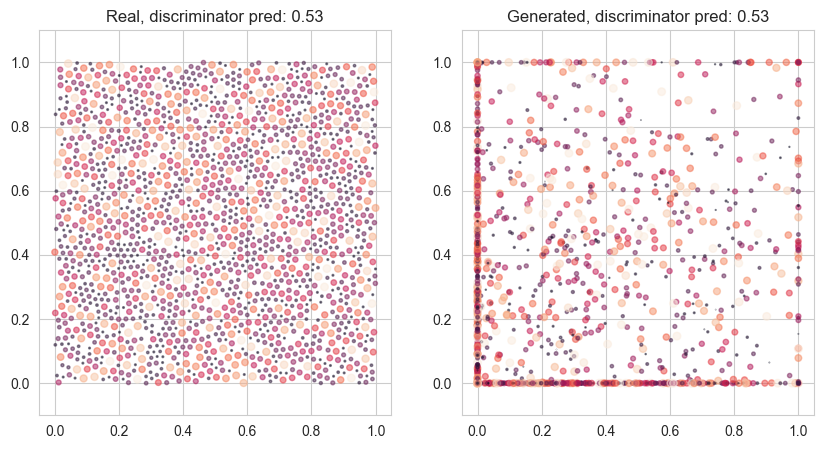

In [418]:
# Check on the created figures

plot_sample_figures(gan.generator, gan.discriminator, dataset, n=2, plot_radius=True)

<Axes: >

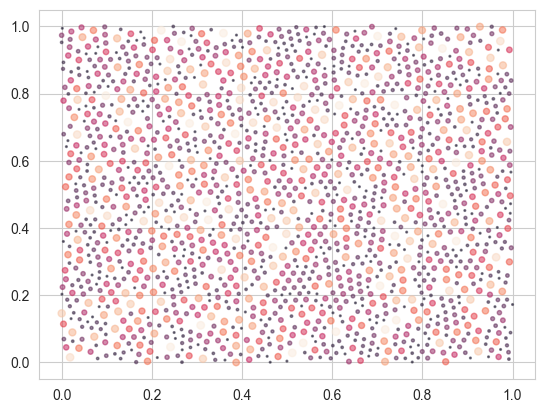

In [273]:
plot_pointcloud(__y[:,:], plot_radius=True)

tensor([[0.0000, 1.4142, 2.8284],
        [1.4142, 0.0000, 1.4142],
        [2.8284, 1.4142, 0.0000]])

In [299]:
__y = sample_y[0].cpu()

print(__y.shape)

distances = torch.cdist(__y[:, :2], __y[:, :2])

# If distances < radius then we have a collision
radius_combinations = __y[:,2].unsqueeze(0) + __y[:,2].unsqueeze(1)

collisions = distances < radius_combinations

# Only consider the upper triangle
collisions = torch.triu(collisions, diagonal=1)

# Get the colliding point
collisions = torch.where(collisions)

# Get the colliding points
colliding_points = torch.unique(collisions[0])

colliding_points.shape


# plot_pointcloud(__y[indices,:], plot_radius=True)

torch.Size([2000, 3])


torch.Size([1998])

In [311]:
r = 1.

vec = torch.tensor([[0., 0., r], [1.,1., r], [2.,2., r*3]])

distances = torch.cdist(vec, vec)
print(distances)
# If distances < radius then we have a collision
radius_combinations = vec[:,2].unsqueeze(0) + vec[:,2].unsqueeze(1)

collisions = distances < radius_combinations

# Only consider the upper triangle
collisions = torch.triu(collisions, diagonal=1)

# Get the colliding points
collisions = torch.where(collisions)

# Get the colliding points
colliding_points = torch.unique(collisions[0])

colliding_points


tensor([[0.0000, 1.4142, 3.4641],
        [1.4142, 0.0000, 2.4495],
        [3.4641, 2.4495, 0.0000]])


tensor([0, 1])

In [ ]:
# Check physical feasibility of the generated point clouds

# Start with summing overlapping areas

def count_overlaps(xs, ys, rs):
    # Count the number of overlaps in the pointcloud
    # Overlapping areas are areas where the radius of a point is larger than the distance to the nearest point minus the radius of the nearest point

    # n_points = pointclouds.shape[0]
    # overlaps = 0

    # distances = torch.cdist(pointclouds, pointclouds)
    pass
    

   


# Check if the sum of overlapping areas is correct
# pointclouds = dataset[:][1]
# count_overlaps(pointclouds)


# Profile model performance for computational bottlenecks

In [152]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        gan.generator(sample_x)

    # print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))


In [151]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=20))

--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                 model_inference         0.64%       2.129ms       100.00%     332.285ms     332.285ms             1  
                aten::batch_norm         0.00%       6.208us        98.77%     328.188ms     164.094ms             2  
    aten::_batch_norm_impl_index         0.00%      16.417us        98.77%     328.181ms     164.091ms             2  
         aten::native_batch_norm        98.75%     328.147ms        98.76%     328.164ms     164.082ms             2  
                    aten::conv2d         0.00%       8.125us         0.18%     611.590us     203.863us             3  
               aten::convolution         0.01%  

In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        gan.discriminator(sample_y)

    # print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))


: 

In [ ]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=20))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference        26.75%       4.685ms       100.00%      17.513ms      17.513ms             1  
                     aten::conv2d         0.22%      39.000us        58.93%      10.321ms       2.064ms             5  
                aten::convolution         0.50%      88.000us        58.71%      10.282ms       2.056ms             5  
               aten::_convolution         0.36%      63.000us        58.21%      10.194ms       2.039ms             5  
         aten::mkldnn_convolution        57.36%      10.045ms        57.85%      10.131ms       2.026ms             5  
                 aten::leaky_relu       

### OPEN QUESTIONS

- What to do with the metadata?
- Class and radius are redundant. Is the real physical measure numerical or categorical / quantified? 

In [ ]:
metadata.round(5).drop_duplicates()

,,N,L,A
experiment,sample,,,
phi-0.74,sample-245,2000,46.88709,1626.81571
phi-0.72,sample-245,2000,47.53384,1626.81571
phi-0.70,sample-245,2000,48.20812,1626.81571
